In [1]:
import numpy as np
from scipy.signal import convolve
from signal_utils import *

def design_farrow(order):
    """
    Design Farrow subfilters for a given polynomial 'order'.
    Returns:
      taps : integer array of length (order+1)
             (e.g. for order=4 → taps = [-2, -1, 0, 1, 2])
      B    : (order+1)×(order+1) matrix where B[k, i] is the coefficient
             of delta^k for tap = taps[i].
    """
    M = order
    # 1) Choose a symmetric (or nearly symmetric) stencil around zero:
    if M % 2 == 0:
        L = M // 2
        taps = np.arange(-L, L + 1)
    else:
        L = M // 2
        taps = np.arange(-L, L + 2)

    taps = taps.astype(int)
    K = len(taps)  # should be M + 1

    # 2) Allocate matrix for polynomial coefficients c_{i,k}:
    B = np.zeros((M + 1, K), dtype=float)

    for i in range(K):
        # 2a) Denominator for ℓ_i(δ):
        #     denom_i = ∏_{j ≠ i} (taps[i] - taps[j])
        denom = 1.0
        for j in range(K):
            if j == i:
                continue
            denom *= (taps[i] - taps[j])

        # 2b) Build numerator polynomial ∏_{j≠i} (δ - taps[j]):
        #     Start from the constant polynomial “1.0” and convolve iteratively
        num_poly = np.array([1.0])
        for j in range(K):
            if j == i:
                continue
            # Convolve current polynomial with (δ - taps[j]) → coefficients [1, -taps[j]]
            num_poly = np.convolve(num_poly, np.array([1.0, -float(taps[j])]))

        # 2c) ℓ_i(δ) = (num_poly) / denom  →  expand to get c_{i,k} = num_poly[k]/denom
        for k in range(M + 1):
            B[k, i] = num_poly[k] / denom

    return taps, B


def farrow_delay(signal, order, delta):
    """
    Apply a fixed fractional delay `delta` (0 ≤ delta < 1) to `signal`
    using a Farrow filter of given `order`. Returns an array of the same length
    as `signal`.

    Internally:
      1) Designs the Farrow subfilters (length = order+1).
      2) Zero-pads `signal` so that the output length matches the input.
      3) Convolves each subfilter with the padded signal, extracts the "valid"
         portion, multiplies by delta^k, and accumulates.

    Args:
      signal : 1D NumPy array of input samples.
      order  : Polynomial order of the Farrow filter (e.g., 4 or 5).
      delta  : Fractional delay in [0, 1).

    Returns:
      y : 1D NumPy array of length = len(signal), where
          y[n] ≈ signal[n + delta], up to polynomial interpolation error of order (order+1).
    """
    # 1) Design subfilters:
    taps, B = design_farrow(order)
    m_min = int(np.min(taps))
    m_max = int(np.max(taps))
    K = len(taps)  # = order + 1

    # 2) Zero-pad so output stays same length as input:
    pad_left = m_max        # number of zeros to prepend
    pad_right = -m_min      # number of zeros to append
    x_padded = np.pad(signal, (pad_left, pad_right), mode='constant', constant_values=0.0)

    # Precompute powers of delta:
    M_plus1 = order + 1
    delta_pows = np.array([delta**k for k in range(M_plus1)], dtype=float)
    N = len(signal)
    y = np.zeros(N, dtype=float)

    # 3) Build “compact” FIR subfilters of length K,
    #    aligned so index j ↦ tap = (m_min + j).
    b_compact = np.zeros((M_plus1, K), dtype=float)
    for k in range(M_plus1):
        for i, tap in enumerate(taps):
            idx = tap - m_min
            b_compact[k, idx] = B[k, i]

    # 4) Convolve each subfilter, extract the valid portion, and accumulate:
    for k in range(M_plus1):
        conv_full = convolve(x_padded, b_compact[k], mode='full')
        # “Valid” portion: indices [K-1 : K-1+N] → length = N
        conv_valid = conv_full[K - 1 : K - 1 + N]
        y += delta_pows[k] * conv_valid

    return y


# --------------------------------------------
# Example usage:
# --------------------------------------------
if __name__ == "__main__":
    # 1) Generate a test signal (e.g., a slow sine wave)
    N = 2**16
    n = np.arange(N)
    F = 0.02
    x = np.sin(2 * np.pi * F * n)

    # 2) Choose Farrow order and fractional delay
    order = 107
    delta = 0.37

    # 3) Apply Farrow delay
    y_delayed = farrow_delay(x, order, delta)
    y_delayed /= np.max(y_delayed)

    # 4) Quick sanity check: print first few samples
    print("Original x[:10]:   ", np.round(x[:10], 4))
    print("Delayed y[:10]:    ", np.round(y_delayed[:10], 4))
    print("Length check: len(x) =", len(x), ", len(y_delayed) =", len(y_delayed))


Original x[:10]:    [0.     0.1253 0.2487 0.3681 0.4818 0.5878 0.6845 0.7705 0.8443 0.9048]
Delayed y[:10]:     [-0.0031  0.0046 -0.0083  0.0268  0.1667  0.2824  0.4041  0.5134  0.6183
  0.7112]
Length check: len(x) = 65536 , len(y_delayed) = 65536


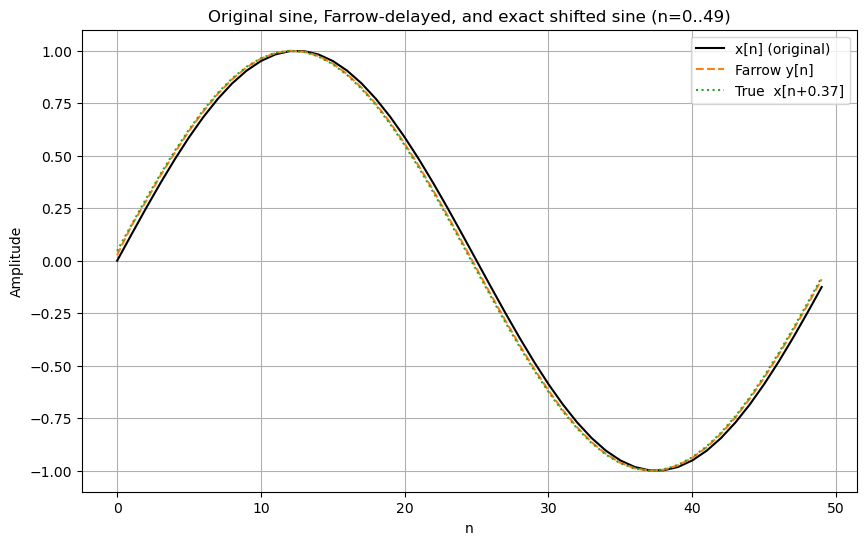

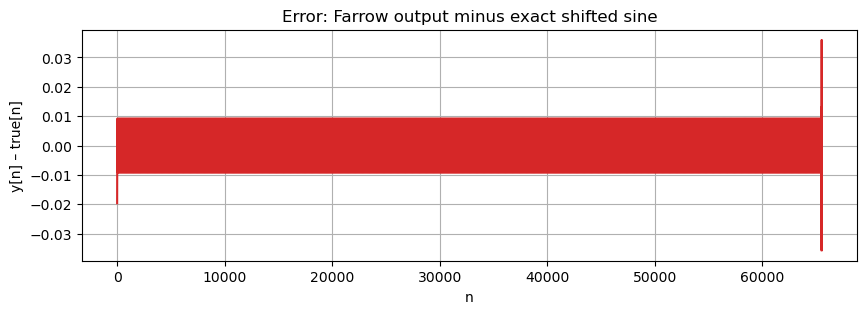

[-0.01963516 -0.00458476 -0.01102542 ... -0.01495691  0.03584569
 -0.03563481]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Original sine (frequency = 0.02) and Farrow‐delayed version:
x      = np.sin(2*np.pi*F * n)
y_del  = y_delayed  # ← the array you posted

# 2) Ground truth: exact shift by delta = 0.37
delta = 0.37
y_true = np.sin(2*np.pi*F * (n + delta))

# 3) Plot original vs. delayed vs. true‐shift (zoom‐in on the first 50 samples)
plt.figure(figsize=(10, 6))

plt.plot(n[:50], x[:50],       'k-',  label="x[n] (original)")
plt.plot(n[:50], y_del[3:50+3],   'C1--',label="Farrow y[n]")
plt.plot(n[:50], y_true[:50],  'C2:', label="True  x[n+0.37]")

plt.legend()
plt.xlabel("n")
plt.ylabel("Amplitude")
plt.title("Original sine, Farrow‐delayed, and exact shifted sine (n=0..49)")
plt.grid(True)
plt.show()

# 4) Plot the interpolation error y_del−y_true over all n
error = y_del[3:] - y_true[:-3]
plt.figure(figsize=(10, 3))
plt.plot( error, 'C3-')
plt.xlabel("n")
plt.ylabel("y[n] – true[n]")
plt.title("Error: Farrow output minus exact shifted sine")
plt.grid(True)
plt.show()

print(error)

In [3]:
C0 = np.array([-0.1667, 0.5, -0.5, 0.1667])
C1 = np.array([0.5, -1, 0.5, 0])
C2 = np.array([-0.3333, -0.5, 1, -1.1667])
C3 = np.array([0, 1, 0, 0])
C = [C0, C1, C2, C3]

# Reverse each Ci to get Hi
H = [np.flip(Ci) for Ci in C]
# Display H
for i, Hi in enumerate(H):
    print(f"H{i} =", Hi)

H0 = [ 0.1667 -0.5     0.5    -0.1667]
H1 = [ 0.   0.5 -1.   0.5]
H2 = [-1.1667  1.     -0.5    -0.3333]
H3 = [0 0 1 0]


In [8]:
def farrow_filter(x, delta):
    C0 = np.array([-0.1667, 0.5, -0.5, 0.1667])
    C1 = np.array([0.5, -1, 0.5, 0])
    C2 = np.array([-0.3333, -0.5, 1, -1.1667])
    C3 = np.array([0, 1, 0, 0])
    C = [C0, C1, C2, C3]
    # Reverse each Ci to get Hi
    H = [np.flip(Ci) for Ci in C]

    y0 = signal.lfilter(H[0], 1.0, x)
    y1 = signal.lfilter(H[1], 1.0, x)
    y2 = signal.lfilter(H[2], 1.0, x)
    y3 = signal.lfilter(H[3], 1.0, x)

    y = y3 + delta*(y2 + delta*(y1 + delta*y0))
        
    return y

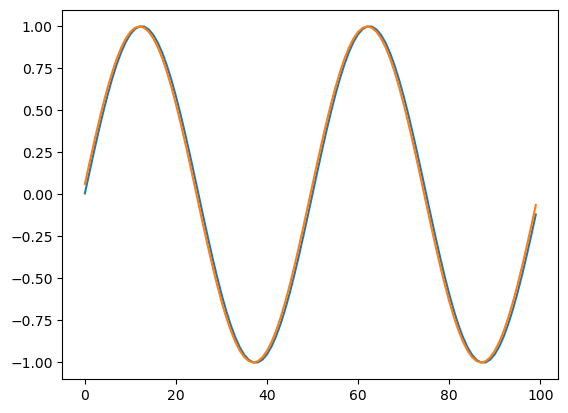

[0.05637654 0.05548745 0.05372328 ... 0.0386687  0.04352475 0.0476944 ]


In [26]:
N = 1024
n = np.arange(N)
F = 0.02
x = 1.0 * np.sin(2*np.pi*F*n)

delta = 0.5

x_farrow = farrow_filter(x, delta)
x_farrow /= np.max(x_farrow)
x_delay = 1.0 * np.sin(2*np.pi*F*(n+delta))
x_delay /= np.max(x_delay)

c = 3
error = np.abs(x_farrow[c:] - x_delay[:-c])

plt.plot(x_farrow[c:100+c])
plt.plot(x_delay[:100])
plt.show();

print(error)